# Augmented Reality App

# Imports and setup

In [26]:
import cv2
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

# Load Marker and Source images

Marker reference image:

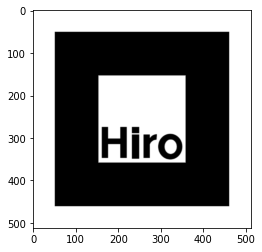

In [27]:
reference_image = cv2.imread('../img/hiro.png', 0)

plt.imshow(reference_image, cmap='gray')
plt.show()

Source image that contains the marker:

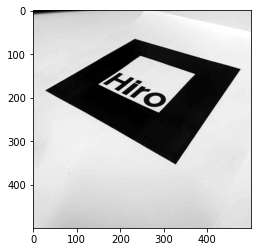

In [28]:
image = cv2.imread('../img/src_hiro-diagonal.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap='gray')
plt.show()

Images are converted to gray scale for better processing.

# Square detection

Convert the image to grayscale

In [29]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Apply GaussianBlur to reduce noise and help Canny edge detection

In [30]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

Apply Canny edge detection

In [31]:
edges = cv2.Canny(blurred, 50, 150)  # Parameters tuned according to the source image 

"Number of edges detected:", len(edges)

('Number of edges detected:', 500)

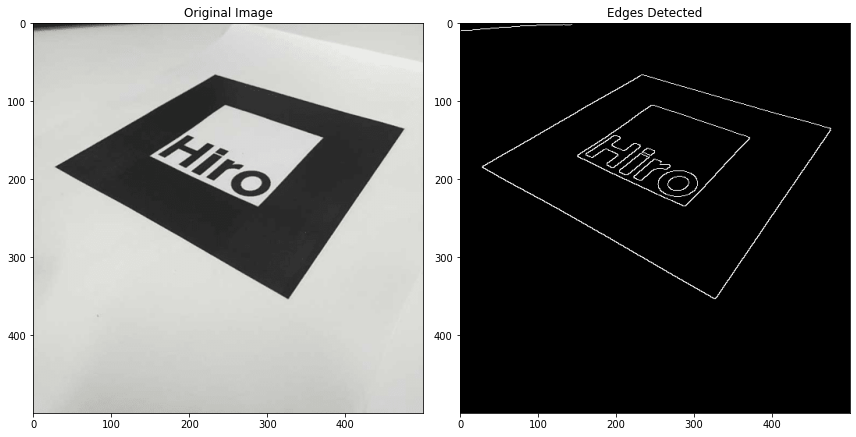

In [32]:
# Create a larger figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')

# Plot the edges
axes[1].imshow(edges, cmap='gray')
axes[1].set_title('Edges Detected')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Find lines using HoughLinesP

In [33]:
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=50)

"Number of lines found:", len(lines)

('Number of lines found:', 14)

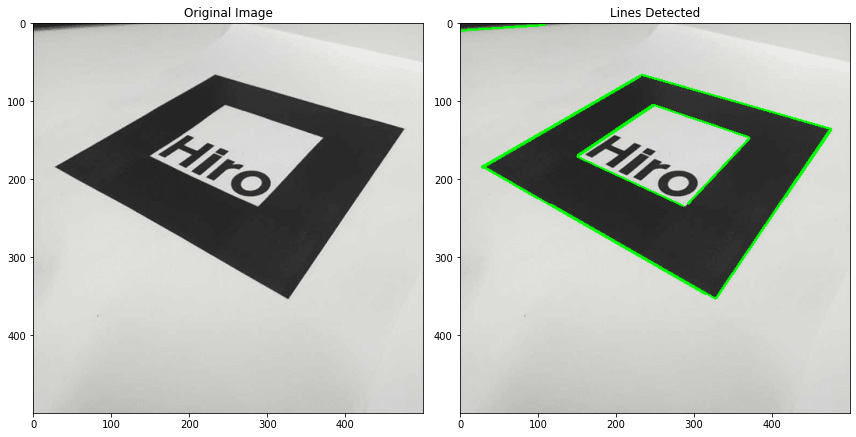

In [34]:
# Create a larger figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')

# Create a copy of the image for drawing lines
line_image = np.copy(image)

# Draw lines on the copy
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Plot the image with lines
axes[1].imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
axes[1].set_title('Lines Detected')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Find intersections of lines

In [35]:
def find_intersections(lines, image_shape, border_threshold=10, min_intersection_distance=150):
    intersections = []

    def distance(pt1, pt2):
        return np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)

    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            x1, y1, x2, y2 = lines[i][0]
            x3, y3, x4, y4 = lines[j][0]

            # Check if the lines are not too parallel
            angle_threshold = np.radians(15)
            if np.abs(np.arctan2(y2 - y1, x2 - x1) - np.arctan2(y4 - y3, x4 - x3)) > angle_threshold:
                # Calculate intersection point
                det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
                if det != 0:
                    intersection_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / det
                    intersection_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / det

                    # Check if the intersection point is within the image bounds
                    if (
                        border_threshold <= intersection_x < image_shape[1] - border_threshold and
                        border_threshold <= intersection_y < image_shape[0] - border_threshold
                    ):
                        new_intersection = (int(intersection_x), int(intersection_y))

                        # Check the minimum distance to existing intersections
                        if all(distance(new_intersection, intersection) >= min_intersection_distance for intersection in intersections):
                            intersections.append(new_intersection)
    return intersections

In [36]:
intersections = find_intersections(lines, image.shape)

"Number of intersections found:", len(intersections)

('Number of intersections found:', 4)

Plot the intersections

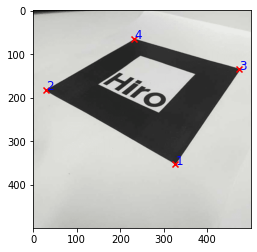

In [37]:
# Plot the original image with intersections
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Plot intersections with IDs
if intersections:
    intersections_array = np.array(intersections)
    plt.scatter(intersections_array[:, 0], intersections_array[:, 1], c='red', marker='x')
    for i, (x, y) in enumerate(intersections):
        plt.text(x, y, f'{i+1}', color='blue', fontsize=12)
plt.show()

# Homography

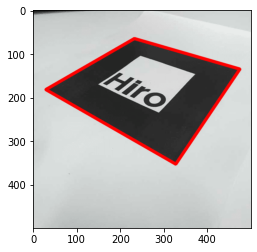

In [38]:
# Matching points from source (marker) and destination (the source image)
h, w = reference_image.shape
REFERENCE_CORNERS = [[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]]
src_points = np.array(REFERENCE_CORNERS, dtype=np.float32)
dst_points = np.array(intersections, dtype=np.float32)

# Obtain the homography matrix
homography, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

# Apply the perspective transformation to the source image corners
corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
transformedCorners = cv2.perspectiveTransform(corners, homography)

# Draw a polygon on the second image joining the transformed corners
homography_image = np.copy(image)
sourceImageMarker = cv2.polylines(homography_image, [np.int32(transformedCorners)], True, 255, 5, cv2.LINE_AA)

# Show image
plt.imshow(homography_image)
plt.show()

## Rendering the 3D model

Load the model

In [39]:
from objloader_simple import *

# Camera parameters
camera_parameters = np.array([[1000, 0, 320], [0, 1000, 240], [0, 0, 1]])

# Load 3D model from OBJ file
obj = OBJ('../models/fox/fox.obj', swapyz=True)

Calculate the projection matrix

In [40]:
def projection_matrix(camera_parameters, homography):
    
    homography = homography * (-1)
    rot_and_transl = np.dot(np.linalg.inv(camera_parameters), homography)
    col_1 = rot_and_transl[:, 0]
    col_2 = rot_and_transl[:, 1]
    col_3 = rot_and_transl[:, 2]
    
    # normalise vectors
    l = math.sqrt(np.linalg.norm(col_1, 2) * np.linalg.norm(col_2, 2))
    rot_1 = col_1 / l
    rot_2 = col_2 / l
    translation = col_3 / l
    
    # compute the orthonormal basis
    c = rot_1 + rot_2
    p = np.cross(rot_1, rot_2)
    d = np.cross(c, p)
    rot_1 = np.dot(c / np.linalg.norm(c, 2) + d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_2 = np.dot(c / np.linalg.norm(c, 2) - d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_3 = np.cross(rot_1, rot_2)
    
    # finally, compute the 3D projection matrix from the model to the current frame
    projection = np.stack((rot_1, rot_2, rot_3, translation)).T
    
    return np.dot(camera_parameters, projection)

Render the model

In [41]:
# project cube or model
SCALE = 2  # Default 6
def render(img, obj, projection, model, color=False):

    vertices = obj.vertices
    scale_matrix = np.eye(3) * SCALE
    h, w = model.shape

    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        points = np.dot(points, scale_matrix)
        # render model in the middle of the reference surface. To do so,
        # model points must be displaced
        points = np.array([[p[0] + w / 2, p[1] + h / 2, p[2]] for p in points])
        dst = cv2.perspectiveTransform(points.reshape(-1, 1, 3), projection)
        imgpts = np.int32(dst)

        cv2.fillConvexPoly(img, imgpts, (80, 27, 211))
    return img

Apply everything to render the model with applied homography

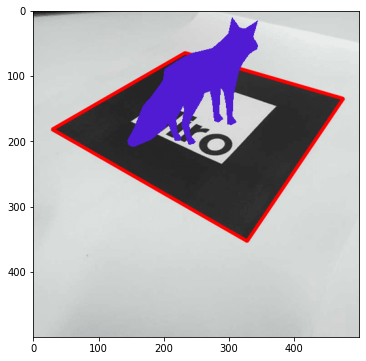

In [42]:
# Draw a polygon on the second image joining the transformed corners
render_image = np.copy(image)
frame = cv2.polylines(render_image, [np.int32(transformedCorners)], True, 255, 3, cv2.LINE_AA)

# obtain 3D projection matrix from homography matrix and camera parameters
projection = projection_matrix(camera_parameters, homography)  

# project cube or model
frame = render(frame, obj, projection, reference_image, False)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(frame, cmap="gray")
plt.show()